<a href="https://colab.research.google.com/github/KristynaPijackova/Radio-Modulation-Recognition-Networks/blob/main/Radio_Modulation_Recognition_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Radio Modulation Recognition Networks

---

**Author: Kristyna Pijackova**

---

This notebook contains code, which is a part of solution for semestral thesis in the academic year 2020/2021. 

---

**This code contains 4 main parts:**


*   **Imports** - Import needed libraries, dataset and define some functions for later
*   **Data Pre-Processing**
*   **Deep Learning Part** - Architecture's design, training the designed models
*   **Results** - Evaluation of the Network, Graphs and Confusion Matrices

---
This code was used in Google Colab enviroment utilizing its free GPU. If you'd like to see how it works feel free to get a copy from the GitHub repository and experiment on your own.

More details are included in the semestral thesis. 

Note: This code is still a work in progress and contains live code, which I find extremely usefull as it allows me to adjust parameters easily and keep a track of what works and what doesn't.

---

**Quick guide to running the document:**

Open  [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb#recent=true) and go to 'GitHub' bookmark. Insert the link to the Github repository. This should open the code for you and allow you to run and adjust it.

*   Use `up` and `down` keys to move in the notebook
*   Use `ctrl+enter` to run cell or choose 'Run All' in Runtime to run the whole document at once 
*   If you change something in specific cell, it's enough to re-run just the cell to save the changes
*   Hide/show sections of the code with the arrows at side, which are next to some cell code







# Imports

Import libraries and dataset needed for training and evaluation.

The dataset has an open-source licension and is avaible at this page [DEEPSIG Dataset](https://www.deepsig.ai/datasets), which is provided open source under the Create Commons Attribution-NonCommercial 4.0 International (CC BY-NC 4.0) Licence
https://creativecommons.org/licenses/by-nc/4.0/ 

The used version is the RML2016.10b containing 10 different modulation types at different SNRs. 


## Import libraries

In [1]:
import pickle
import numpy as np
import pandas as pd
from scipy import signal 
import math
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

## Get the dataset


Using the `!wget` command for direct download of the dataset from the Deepsig website in here. 

In [2]:
!wget !wget http://opendata.deepsig.io/datasets/2016.10/RML2016.10b.tar.bz2?__hstc=21858660.04fa8fb4645ce0eda8db2b479b392975.1582836404707.1585779977029.1585787207373.12&__hssc=21858660.6.1585787207373&__hsfp=1770436128

--2020-12-12 12:33:53--  http://!wget/
Resolving !wget (!wget)... failed: Name or service not known.
wget: unable to resolve host address ‘!wget’
--2020-12-12 12:33:53--  http://opendata.deepsig.io/datasets/2016.10/RML2016.10b.tar.bz2?__hstc=21858660.04fa8fb4645ce0eda8db2b479b392975.1582836404707.1585779977029.1585787207373.12
Resolving opendata.deepsig.io (opendata.deepsig.io)... 52.14.91.165
Connecting to opendata.deepsig.io (opendata.deepsig.io)|52.14.91.165|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1245608913 (1.2G) [application/x-bzip2]
Saving to: ‘RML2016.10b.tar.bz2?__hstc=21858660.04fa8fb4645ce0eda8db2b479b392975.1582836404707.1585779977029.1585787207373.12’

RML2016.10b.tar.bz2 100%[===================>]   1.16G  13.4MB/s    in 87s     

2020-12-12 12:35:20 (13.7 MB/s) - ‘RML2016.10b.tar.bz2?__hstc=21858660.04fa8fb4645ce0eda8db2b479b392975.1582836404707.1585779977029.1585787207373.12’ saved [1245608913/1245608913]

FINISHED --2020-12-12 12:35:20-

The `! python -m tarfile -e` extracts the dataset (note it might be, you need to adjust few last numbers (I found it might differ from notebook to notebook, just look at the 'Saving to:' line and copy without the quation marks... it also need a bit time to unzip)

In [3]:
! python -m tarfile -e RML2016.10b.tar.bz2?__hstc=21858660.04fa8fb4645ce0eda8db2b479b392975.1582836404707.1585779977029.1585787207373.12

Open the extracted dataset and load the pickle file

In [4]:
infile = open('RML2016.10b.dat','rb')
new_dict = pickle.load(infile, encoding='bytes')

## Defined functions to call later

Function for plotting accuracy and loss

In [5]:
def plot_acc_loss():
    """
    Call function to plot accuracy and loss
    """
    plt.subplots(ncols=2, figsize=(20,5))
    plt.subplot(1,2,1)
    plt.title('Training and validation accuracy')
    plt.xlabel('Number of epochs'); plt.ylabel('Accuracy')
    plt.plot(history.history['accuracy'], 'b-', history.history['val_accuracy'], 'r-')
    plt.legend(['training','validation'])
    plt.subplot(1,2,2)
    plt.title('Training and validation loss')
    plt.xlabel('Number of epochs'); plt.ylabel('Loss')
    plt.plot(history.history['loss'], 'b-', history.history['val_loss'], 'r-')
    plt.legend(['training','validation'])

Prints out accuracy of each SNR and shows a simple plot of accuracy over the SNR span

In [6]:
def SNR_accuracy(in_snr):
    """
    Computes accuracies of chosen SNRs individualy
  
    in_snr:   must be list of SNRs
    """
    
    acc = []
    for snr in in_snr:
        acc_snr = snr
        idx_acc_snr = []

        for i in range(len(lbl_test_idx)):
            if int(lbl[lbl_test_idx[i],1]) == int(acc_snr):
                idx_acc_snr.append(i)

        acc_X_test = X_test[idx_acc_snr]
        # acc_X_f_test = X_f_test[idx_acc_snr]
        acc_Y_test = Y_test[idx_acc_snr]

        print('\nSNR ' + str(acc_snr) + 'dB:')
        accuracy_snr = model.evaluate([acc_X_test], acc_Y_test, batch_size=batch_size, verbose=2)
        acc.append(accuracy_snr)

    acc = np.vstack(acc)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    plt.plot(snrs, (acc[:,1]*100),'k', marker='+')

    x_major_ticks = np.arange(-20, 19, 2 )
    ax.set_xticks(x_major_ticks)

    y_major_ticks = np.arange(0, 101, 10 )
    y_minor_ticks = np.arange(0, 101, 2)
    ax.set_yticks(y_major_ticks)
    ax.set_yticks(y_minor_ticks, minor=True)

    ax.grid(which='both',color='lightgray', linestyle='-')

    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)

    plt.xlim(-20, 18)
    plt.ylim(0,100)
    plt.title("Classification Accuracy")
    plt.ylabel('Accuracy (%)')
    plt.xlabel('SNR (dB)')
    plt.show()

Function which compares two lists and returns same indeces...needed when some SNR values are excluded

In [7]:
def return_indices_of_a(a, b):
    """
    Compare two lists a, b for same items and return indeces
    of the item in list a

    a:    List of items, its indeces will be returned
    b:    List of items to search for in list a

    Credit: https://stackoverflow.com/users/97248/pts ; https://stackoverflow.com/questions/10367020/compare-two-lists-in-python-and-return-indices-of-matched-values
    """
    b_set = set(b)
    return [i for i, v in enumerate(a) if v in b_set]

Plots confusion matrix

In [8]:
def show_confusion_matrix(validations, predictions, matrix_snr):
    """
    Plot confusion matrix

    validations:    True Y labels
    predictions:    Predicted Y labels of your model
    matrix_snr:     SNR information for plot's titel

      """
    modulation = []
    for i in range(10):
        modu = mods[i].decode('utf-8')
        modulation.append(modu)

    cm = confusion_matrix(validations, predictions)
    # Normalise
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(cmn, cmap='Blues', annot=True, fmt='.2f', xticklabels=modulation, yticklabels=modulation)
    sns.set(font_scale=1.3)
    plt.title("Confusion Matrix \n SNR  " + str(matrix_snr) )
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show(block=False)

Calls the function show_confusion_matrix and plots confusion matrices for separate SNR values

In [9]:
def SNR_show_confusion_matrix(in_snr, X_test):
    """
    Plot confusion matrices of chosen SNRs

    in_snr:   must be list of SNRs
    X_test:   X_test data
    """
    for snr in in_snr:
        matrix_snr = snr
        m_snr = matrix_snr;

        Y_Pred = []; Y_Test = []; Y_Pred_SNR = []; Y_Test_SNR = []; 
        matrix_snr_index = [];

        prediction = model.predict(X_test)

        for i in range(len(prediction[:,0])):
            Y_Pred.append(np.argmax(prediction[i,:]))
            Y_Test.append(np.argmax(Y_test[i]))

        for i in range(len(lbl)):
            if int(lbl[i,1]) == m_snr:
                matrix_snr_index.append(i)

        indeces_of_Y_test = return_indices_of_a(lbl_test_idx, matrix_snr_index)

        for i in indeces_of_Y_test:
            Y_Pred_SNR.append(Y_Pred[i])
            Y_Test_SNR.append(Y_Test[i])
        show_confusion_matrix(Y_Pred_SNR, Y_Test_SNR, matrix_snr)
     

Calls the function show_confusion_matrix and plots confusion matrix including all SNRs

In [10]:
def All_SNR_show_confusion_matrix(X_test):
    """
    Plot confusion matrix of all SNRs in one

    X_test:   X_test data
    """
    prediction = model.predict(X_test)

    Y_Pred = []; Y_Test = [];

    for i in range(len(prediction[:,0])):
        Y_Pred.append(np.argmax(prediction[i,:]))
        Y_Test.append(np.argmax(Y_test[i]))

    show_confusion_matrix(Y_Pred, Y_Test, chosen_snr_list)

# Pre-Processing

Part of a code, where the data will be sorted, splitted into training and test sets and normalized - in summary prepared before using it for the deep learning

## Prepare variables and lists

`X` contains all the numerical values and has size of 1,200,000 x 2 x 128

`lbl` holds modulation names and SNR values

In [11]:
chosen_snr = -20 
split = 0.8  
X = []
Y = []
lbl = []
idx_chosen_snr = [] 
chosen_snr_list = []
lbl_train_idx = []
lbl_test_idx = []

In [12]:
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], new_dict.keys())))), [1,0])

for mod in mods:
    for snr in snrs:
        X.append(new_dict[(mod,snr)])
        for i in range(new_dict[(mod,snr)].shape[0]):  
          lbl.append((mod,snr))

X = np.vstack(X)
lbl=np.vstack(lbl)
X = np.transpose(X[:,:,:],(0,2,1))

Exludes all signals with SNR lower than the `chosen_snr` variable holds.

In [13]:
mods = np.unique(lbl[:,0])
snrs = np.unique(lbl[:,1])
snrs = list(map(int, snrs))
snrs.sort()

for i in range(len(lbl)):
    if int(lbl[i,1]) >= chosen_snr:
        idx_chosen_snr.append(i)

for i in range(len(snrs)):
    if int(snrs[i]) >= chosen_snr:
        chosen_snr_list.append(snrs[i])

chosen_snr_list = list(map(int, chosen_snr_list))
chosen_snr_list.sort()
X_SNR = X[idx_chosen_snr,:,:]

## One-Hot-Encoding

Encodes modulation types using the one-hot-encoding method.

In [14]:
for i in range(len(lbl)):
    mod = (lbl[i,0])
    Y.append(mod)

mapping = {}
for x in range(len(mods)):
    mapping[mods[x]] = x

# integer representation
for x in range(len(Y)):
    Y[x] = mapping[Y[x]]

one_hot_encode = to_categorical(Y)

## Split the dataset into training set and test set

Splits the dataset with x:y ratio. The ratio depens on the variable `split`.

E.g. if `split = 0.8`, then 80% of the dataset is for training and the rest 20% for testing.




In [15]:
np.random.seed(0)                                                               
n_examples = X_SNR.shape[0]                                                     
n_train = int(n_examples * split)                                               
snr_train_idx = np.random.choice(range(0,n_examples), size=n_train,                                                      
                                 replace=False)                                  
snr_test_idx = list(set(range(0,n_examples))-set(snr_train_idx))                                                         
                                                              
for idx in snr_train_idx:                                                           
    lbl_train_idx.append(idx_chosen_snr[idx])                                                              

for idx in snr_test_idx:                                                              
    lbl_test_idx.append(idx_chosen_snr[idx])   

In [16]:
X_train = X_SNR[snr_train_idx]                                                           
X_test =  X_SNR[snr_test_idx]

Y_train = one_hot_encode[lbl_train_idx]                                               
Y_test = one_hot_encode[lbl_test_idx]

## Normalization 

Done with mean and std values

Don't calculate the mean and std on the testing data and for normalizing use the mean and std values from the testing set!

In [17]:
mean = X_train[:,:,:].mean(axis=0)
X_train[:,:,:] -= mean
std = X_train[:,:,:].std(axis=0)
X_train[:,:,:] /= std

X_test[:,:,:] -= mean
X_test[:,:,:] /= std

# Deep Learning Part

## CNN

In [18]:
verbose = 2
epochs = 200
batch_size = 256

### Desinging the CLDNN model

In [29]:
cnn_in = keras.layers.Input(shape=(128,2))
cnn = keras.layers.ZeroPadding1D(padding=4)(cnn_in)
cnn = keras.layers.Conv1D(filters=50, kernel_size=8, activation='relu')(cnn)
cnn = keras.layers.MaxPool1D(pool_size=2)(cnn)
cnn = keras.layers.Conv1D(filters=50, kernel_size=8, activation='relu')(cnn)
cnn = keras.layers.MaxPool1D(pool_size=2)(cnn)
cnn = keras.layers.Conv1D(filters=50, kernel_size=4, activation='relu')(cnn)
cnn = keras.layers.Dropout(rate=0.6)(cnn)
cnn = keras.layers.MaxPool1D(pool_size=2)(cnn)
cnn = keras.layers.Flatten()(cnn)
cnn = keras.layers.Dense(70, activation='selu')(cnn)
cnn_out = keras.layers.Dense(10, activation='softmax')(cnn)
model_cnn = keras.models.Model(cnn_in, cnn_out)
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_cnn_model.h5", save_best_only=True, monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.3, patience=3, min_lr=0.00007),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, verbose=1)]
optimizer = keras.optimizers.Adam(learning_rate=0.0007)
model_cnn.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

### Start the training

In [30]:
tf.keras.backend.clear_session()
history = model_cnn.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_split=0.15, callbacks=callbacks)

Epoch 1/200
3188/3188 - 15s - loss: 1.2277 - accuracy: 0.4825 - val_loss: 1.1084 - val_accuracy: 0.5383
Epoch 2/200
3188/3188 - 14s - loss: 1.0984 - accuracy: 0.5354 - val_loss: 1.0625 - val_accuracy: 0.5503
Epoch 3/200
3188/3188 - 14s - loss: 1.0720 - accuracy: 0.5471 - val_loss: 1.0502 - val_accuracy: 0.5560
Epoch 4/200
3188/3188 - 14s - loss: 1.0570 - accuracy: 0.5538 - val_loss: 1.0390 - val_accuracy: 0.5606
Epoch 5/200
3188/3188 - 14s - loss: 1.0458 - accuracy: 0.5592 - val_loss: 1.0381 - val_accuracy: 0.5631
Epoch 6/200
3188/3188 - 14s - loss: 1.0389 - accuracy: 0.5625 - val_loss: 1.0288 - val_accuracy: 0.5672
Epoch 7/200
3188/3188 - 14s - loss: 1.0338 - accuracy: 0.5650 - val_loss: 1.0251 - val_accuracy: 0.5699
Epoch 8/200
3188/3188 - 14s - loss: 1.0296 - accuracy: 0.5673 - val_loss: 1.0253 - val_accuracy: 0.5628
Epoch 9/200
3188/3188 - 14s - loss: 1.0248 - accuracy: 0.5709 - val_loss: 1.0176 - val_accuracy: 0.5783
Epoch 10/200
3188/3188 - 14s - loss: 1.0206 - accuracy: 0.5744 -

### See how the model does on the test data

In [ ]:
model = keras.models.load_model("best_cnn_model.h5")
test_loss, test_acc = model.evaluate(X_test, Y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

## CLDNN 

In [ ]:
verbose = 2
epochs = 200
batch_size = 256

### Desinging the CLDNN model

In [ ]:
cldnn_in = keras.layers.Input(shape=(128,2))
cldnn = keras.layers.Conv1D(filters=64, kernel_size=8, activation='relu')(cldnn_in)
cldnn = keras.layers.MaxPool1D(pool_size=2)(cldnn)
cldnn = keras.layers.LSTM(64, return_sequences=True,)(cldnn)
cldnn = keras.layers.Dropout(0.4)(cldnn)
cldnn = keras.layers.LSTM(64, return_sequences=True,)(cldnn)
cldnn = keras.layers.Dropout(0.4)(cldnn)
cldnn = keras.layers.Flatten()(cldnn)
cldnn_out = keras.layers.Dense(len(mods), activation='softmax')(cldnn)
model_cldnn = keras.models.Model(cldnn_in, cldnn_out)
optimizer = keras.optimizers.Adam(learning_rate=0.0007)
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_cldnn_model.h5", save_best_only=True, monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.4, patience=3, min_lr=0.000007),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, verbose=1)]
model_cldnn.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

### Start the training

In [ ]:
tf.keras.backend.clear_session()
history = model_cldnn.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_split=0.15, callbacks=callbacks)

Epoch 1/200
3188/3188 - 34s - loss: 1.2436 - accuracy: 0.4702 - val_loss: 1.1216 - val_accuracy: 0.5077
Epoch 2/200
3188/3188 - 33s - loss: 1.0866 - accuracy: 0.5357 - val_loss: 1.0324 - val_accuracy: 0.5617
Epoch 3/200
3188/3188 - 33s - loss: 1.0311 - accuracy: 0.5604 - val_loss: 1.0139 - val_accuracy: 0.5718
Epoch 4/200
3188/3188 - 33s - loss: 1.0106 - accuracy: 0.5692 - val_loss: 0.9949 - val_accuracy: 0.5790
Epoch 5/200
3188/3188 - 34s - loss: 0.9982 - accuracy: 0.5767 - val_loss: 0.9838 - val_accuracy: 0.5860
Epoch 6/200
3188/3188 - 34s - loss: 0.9822 - accuracy: 0.5922 - val_loss: 0.9704 - val_accuracy: 0.6027
Epoch 7/200
3188/3188 - 34s - loss: 0.9643 - accuracy: 0.6052 - val_loss: 0.9524 - val_accuracy: 0.6130
Epoch 8/200
3188/3188 - 34s - loss: 0.9503 - accuracy: 0.6135 - val_loss: 0.9384 - val_accuracy: 0.6210
Epoch 9/200
3188/3188 - 34s - loss: 0.9401 - accuracy: 0.6188 - val_loss: 0.9314 - val_accuracy: 0.6251
Epoch 10/200
3188/3188 - 34s - loss: 0.9319 - accuracy: 0.6229 -

### See how the model does on the test data

In [ ]:
model = keras.models.load_model("best_cldnn_model.h5")
test_loss, test_acc = model.evaluate(X_test, Y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

7500/7500 [==============================] - 32s 4ms/step - loss: 0.8802 - accuracy: 0.6453
Test accuracy 0.645270824432373
Test loss 0.880159854888916


# Results

## Look closer at the model and the results

In [25]:
model_cnn.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 2)]          0         
_________________________________________________________________
zero_padding1d (ZeroPadding1 (None, 136, 2)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 129, 50)           850       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 64, 50)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 57, 50)            20050     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 28, 50)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 25, 50)           

In [ ]:
model_cldnn.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 2)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 121, 64)           1088      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 60, 64)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 60, 64)            33024     
_________________________________________________________________
dropout (Dropout)            (None, 60, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 64)            33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 64)           

In [ ]:
plot_model(model_cnn)

In [ ]:
plot_model(model_cldnn)

In [ ]:
plot_acc_loss()


SNR -20dB:
47/47 - 0s - loss: 2.3542 - accuracy: 0.1035

SNR -18dB:
48/48 - 0s - loss: 2.3282 - accuracy: 0.1114

SNR -16dB:
48/48 - 0s - loss: 2.2760 - accuracy: 0.1230

SNR -14dB:
47/47 - 0s - loss: 2.1818 - accuracy: 0.1491

SNR -12dB:
46/46 - 0s - loss: 2.0518 - accuracy: 0.1945

SNR -10dB:
47/47 - 0s - loss: 1.8241 - accuracy: 0.2878

SNR -8dB:
47/47 - 0s - loss: 1.5420 - accuracy: 0.3813

SNR -6dB:
48/48 - 0s - loss: 1.1774 - accuracy: 0.5110

SNR -4dB:
47/47 - 0s - loss: 0.7769 - accuracy: 0.6527

SNR -2dB:
47/47 - 0s - loss: 0.4884 - accuracy: 0.7755

SNR 0dB:
48/48 - 0s - loss: 0.3126 - accuracy: 0.8512

SNR 2dB:
47/47 - 0s - loss: 0.2499 - accuracy: 0.8807

SNR 4dB:
47/47 - 0s - loss: 0.2409 - accuracy: 0.8814

SNR 6dB:
48/48 - 0s - loss: 0.2275 - accuracy: 0.8890

SNR 8dB:
47/47 - 0s - loss: 0.2245 - accuracy: 0.8930

SNR 10dB:
47/47 - 0s - loss: 0.2200 - accuracy: 0.8948

SNR 12dB:
48/48 - 0s - loss: 0.2214 - accuracy: 0.8918

SNR 14dB:
47/47 - 0s - loss: 0.2188 - accuracy

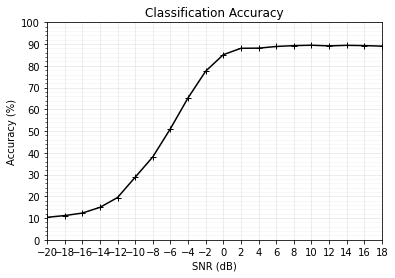

In [28]:
SNR_accuracy(chosen_snr_list)

## Plot confusion matrix

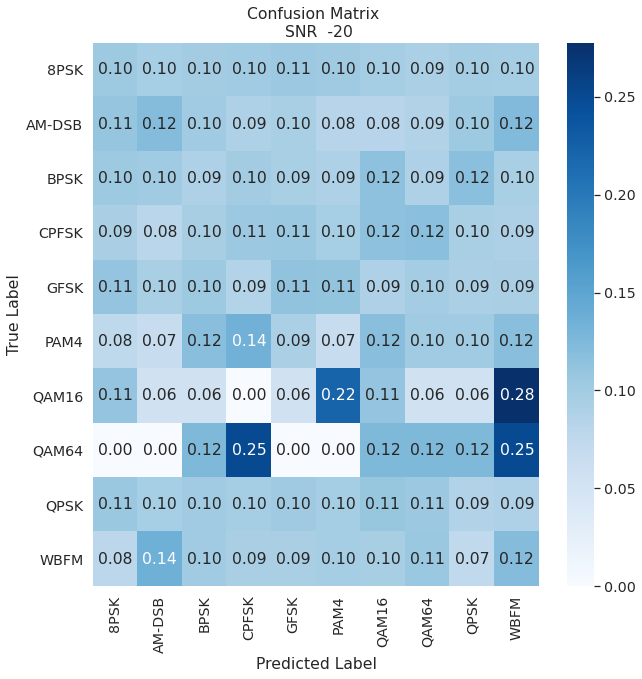

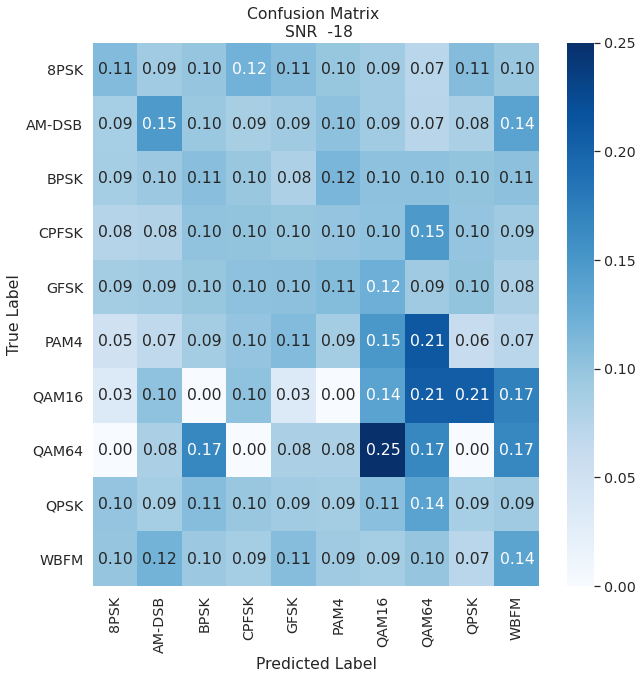

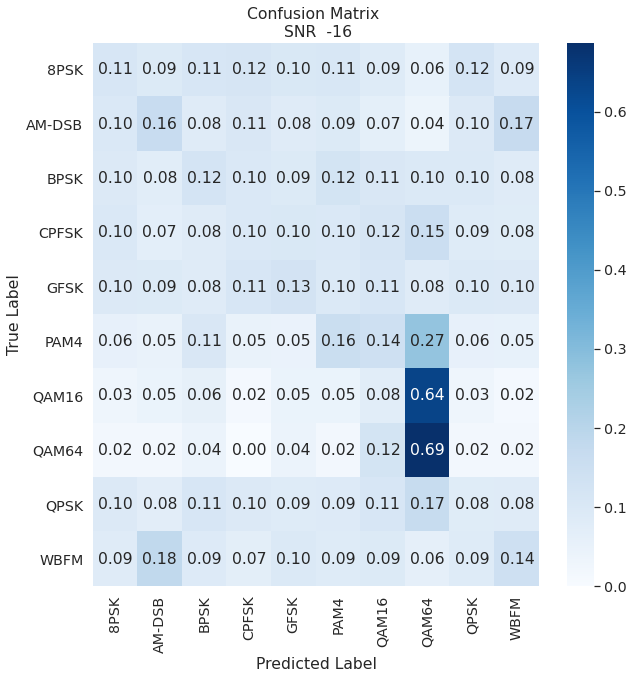

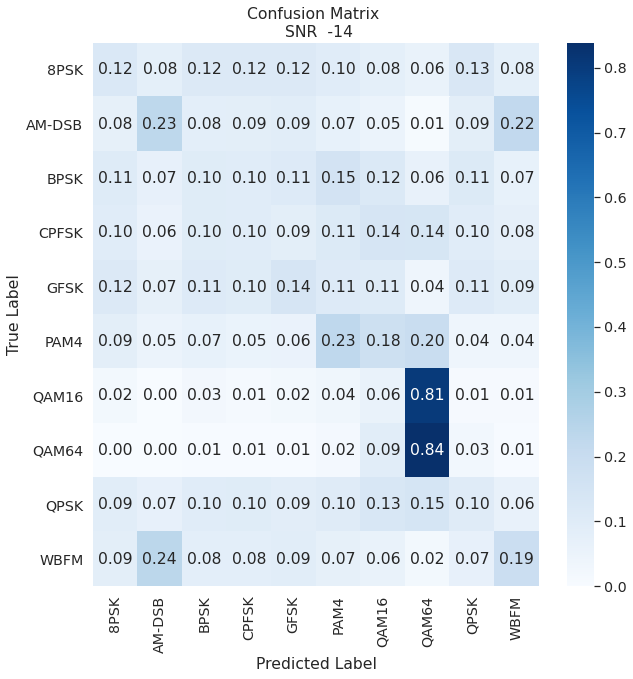

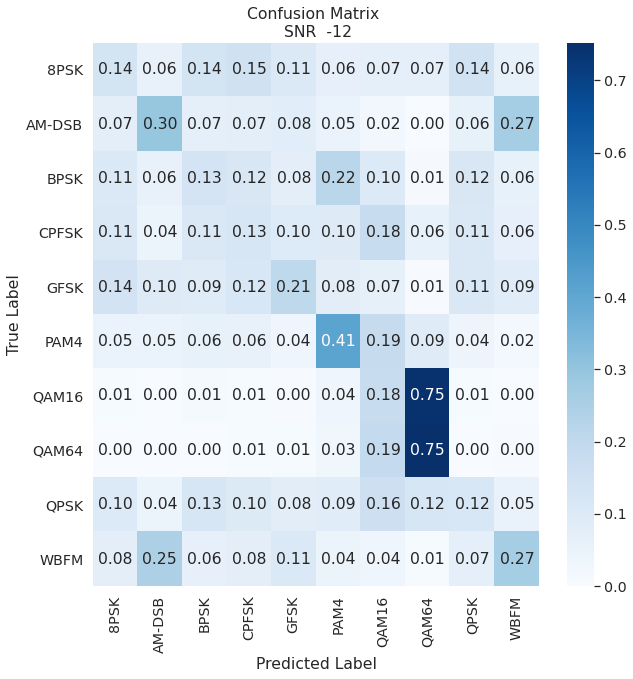

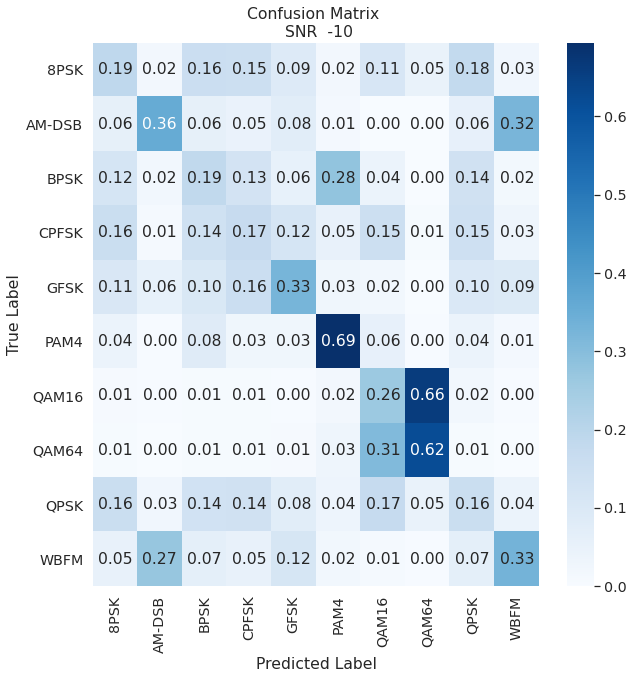

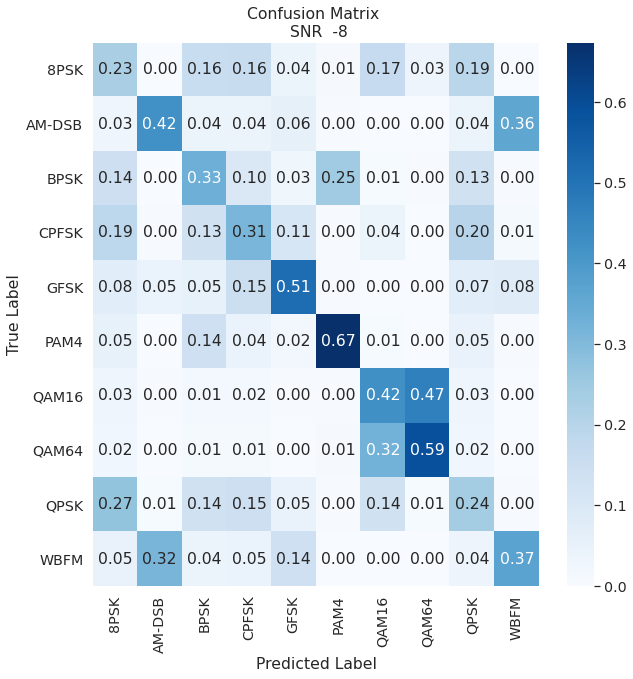

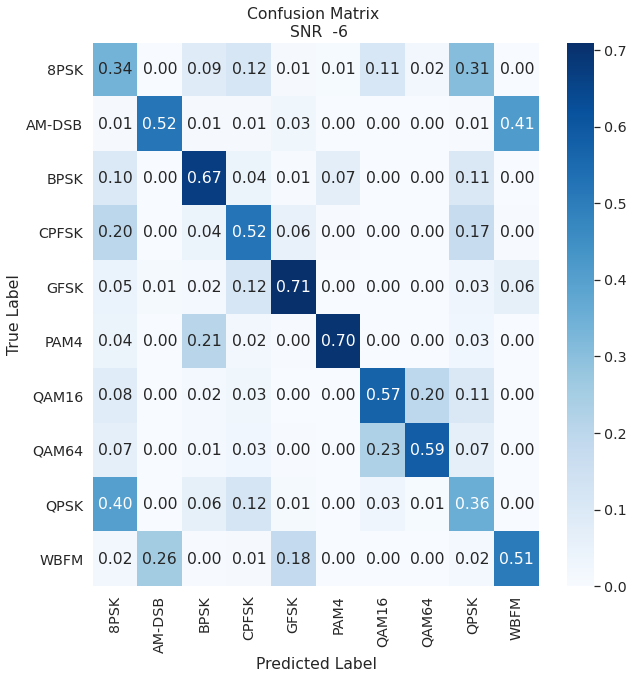

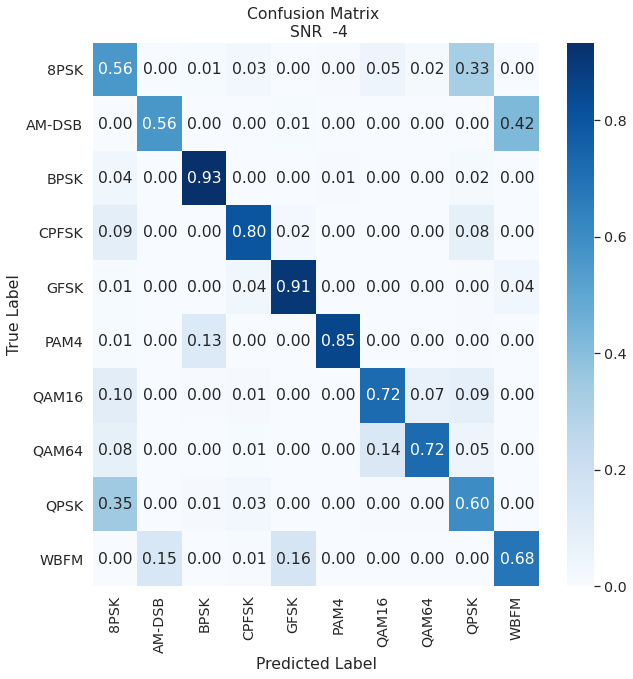

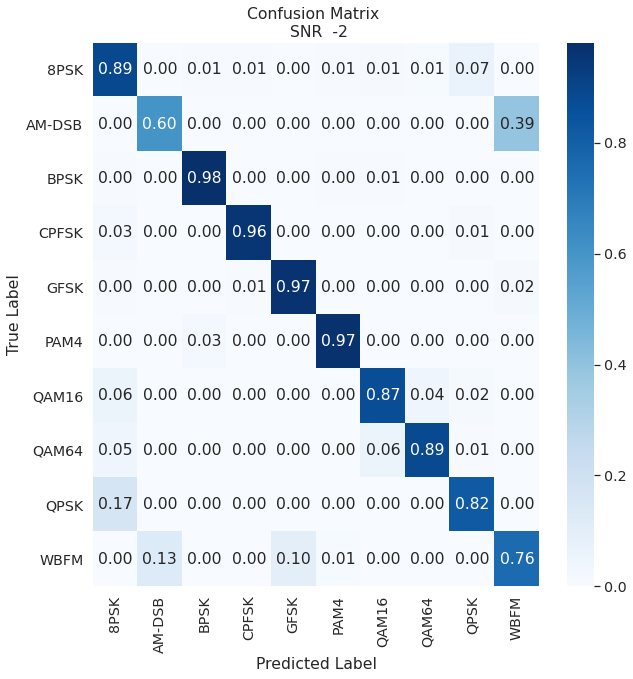

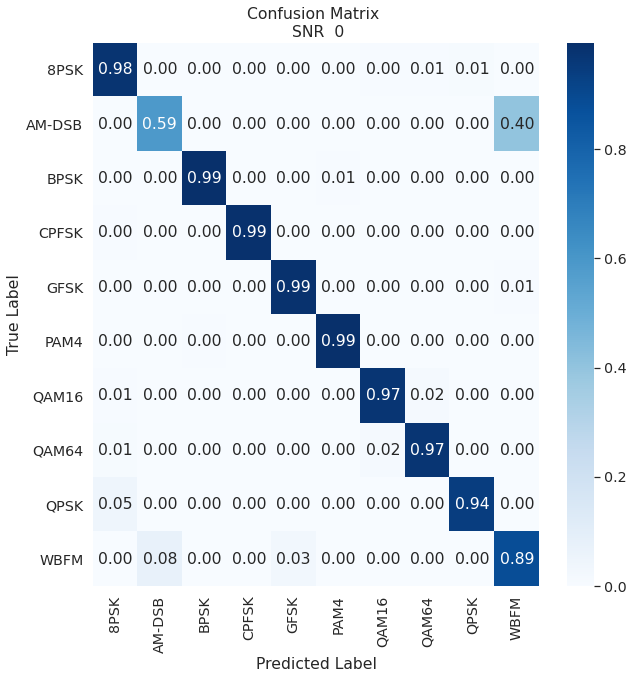

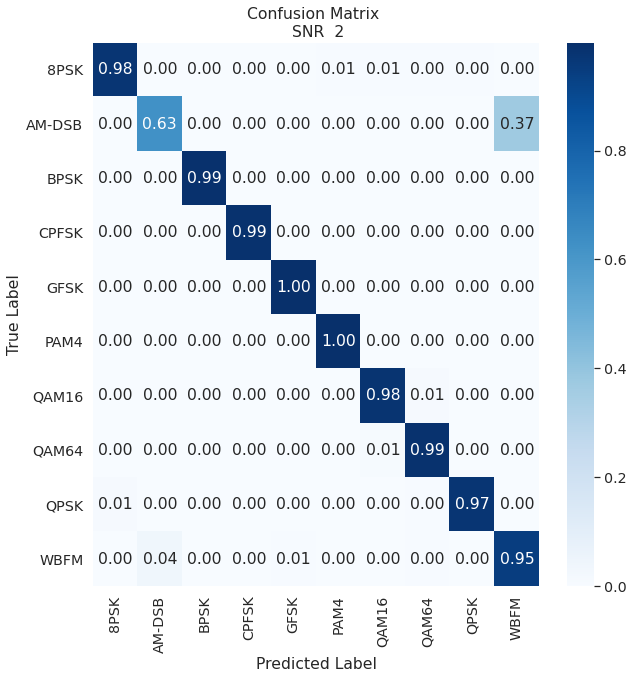

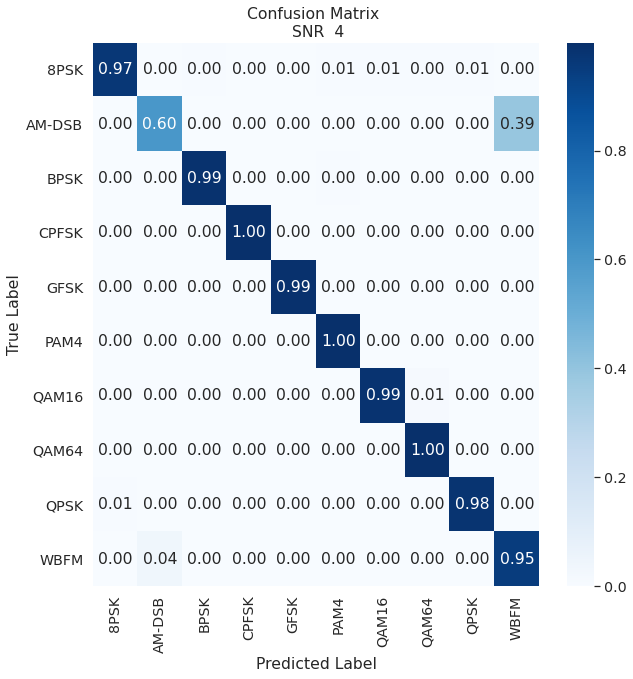

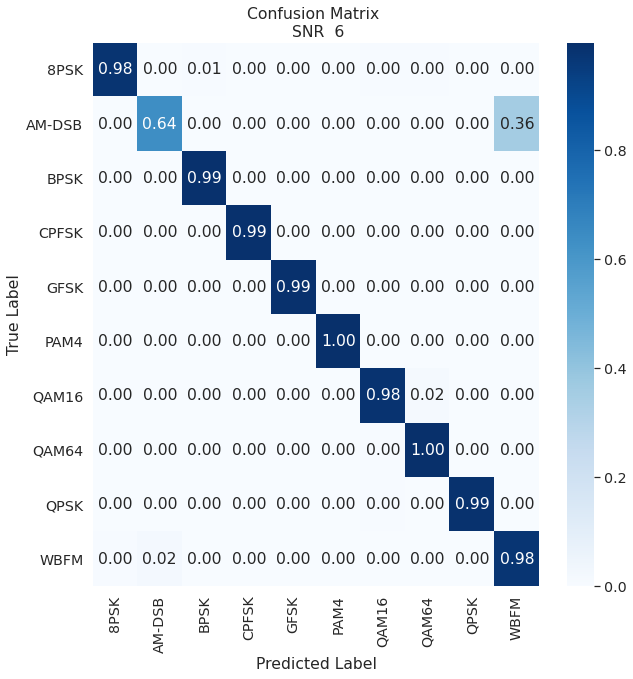

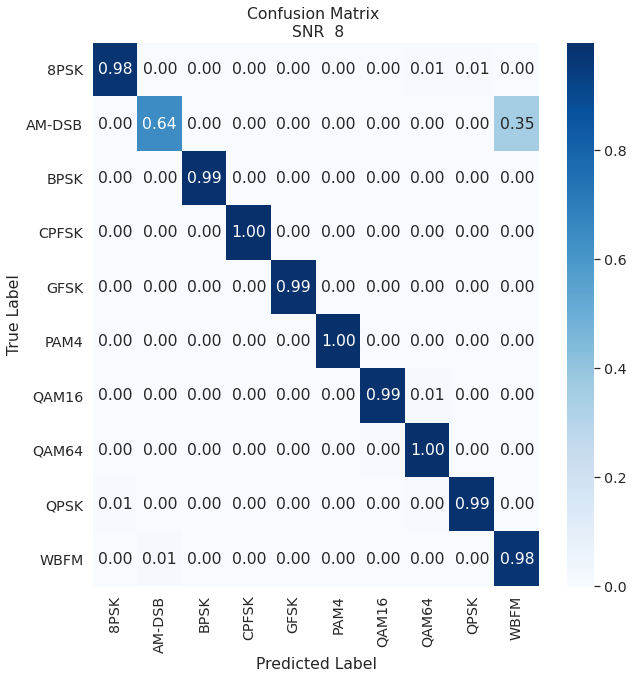

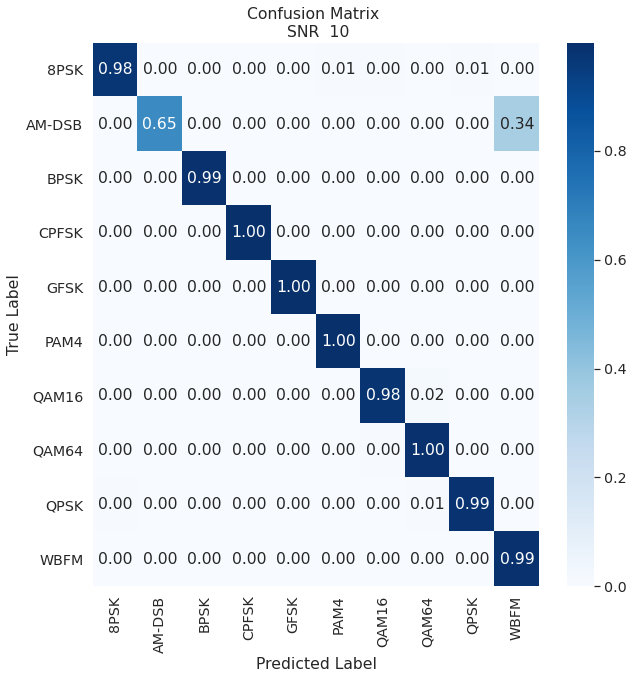

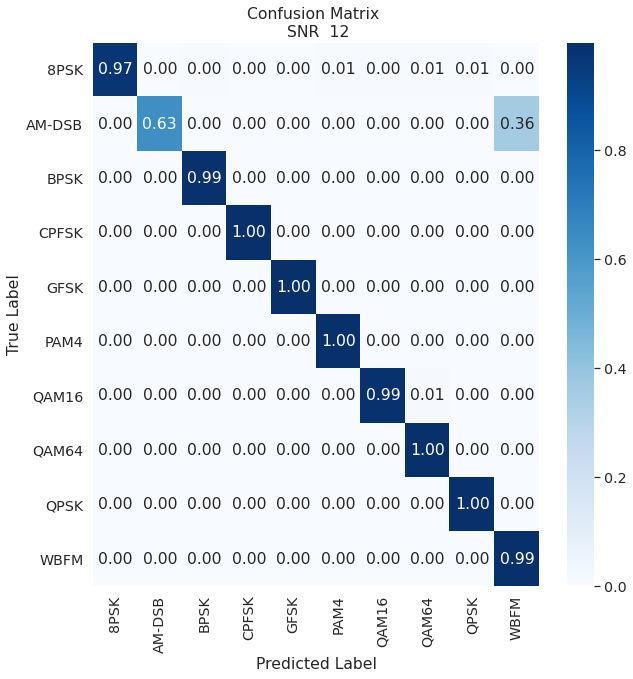

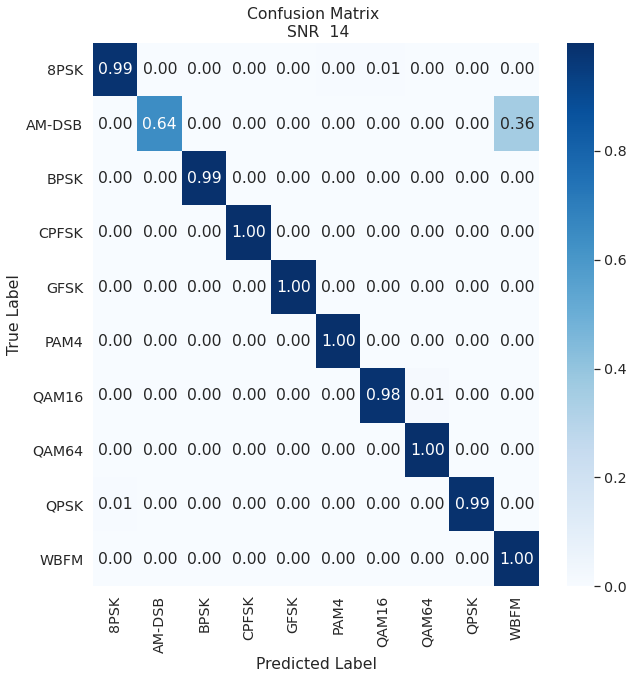

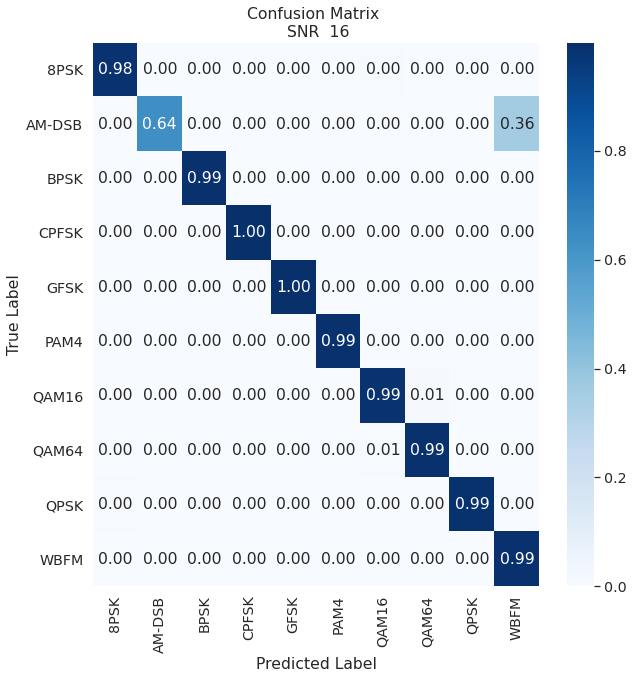

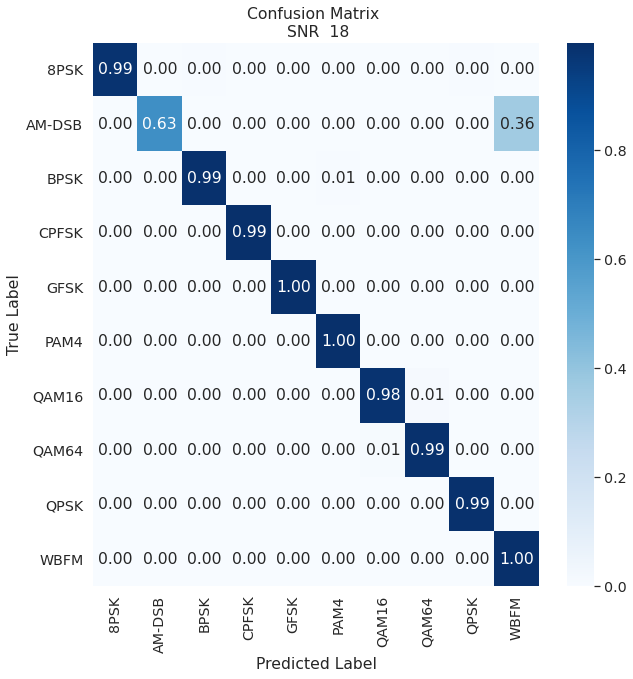

In [ ]:
SNR_show_confusion_matrix(chosen_snr_list, [X_test])

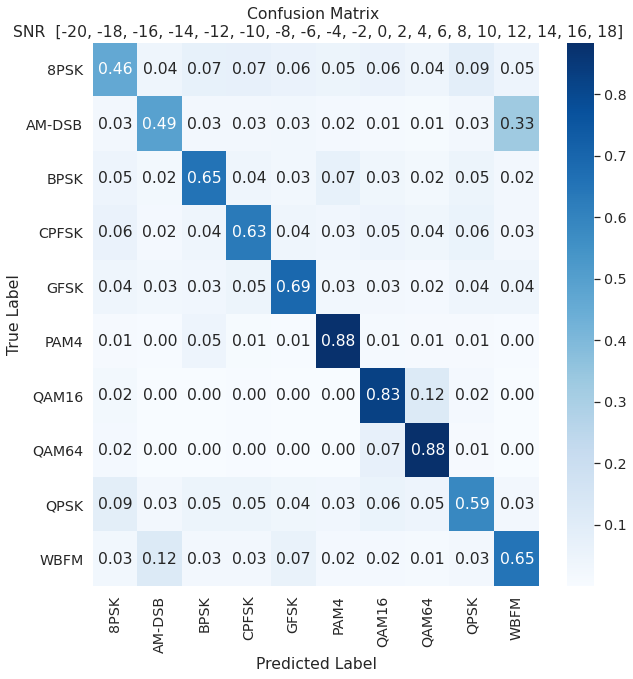

In [ ]:
All_SNR_show_confusion_matrix([X_test])